In [424]:
import pickle
import pandas as pd
import numpy as np

import sys
sys.path.append("C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/src")  # Adjust this path as needed
from metrics import rmse_value, pearson_correlation, snr
from vis import plot_eeg

In [425]:
data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset.pkl"
with open(data_path, "rb") as f:
    eeg_datasets_dict = pickle.load(f)
#eeg_datasets_dict
results_emd_dataset = eeg_datasets_dict["results_emd_denoising"]
results_eemd_dataset = eeg_datasets_dict["results_eemd_denoising"]
original_eeg_dataset = eeg_datasets_dict["original_eeg"]
results_emd_threshold_dataset = eeg_datasets_dict["results_emd_threshold"]
results_eemd_threshold_dataset = eeg_datasets_dict["results_eemd_threshold"]

In [426]:
original_eeg_dataset["dataset_original"].keys()

dict_keys(['channel_names', 'original_scaled_eeg'])

In [427]:
original_eeg = original_eeg_dataset["dataset_original"]["original_scaled_eeg"]
channel_names = original_eeg_dataset["dataset_original"]["channel_names"]
noisy_eeg = original_eeg_dataset["dataset_noisy"]["noisy_scaled_eeg"]

# Evaluation of Gaussian noise denoising

In [428]:
#Calculating Metrics for EMD

metrics_results = pd.DataFrame(columns=["IMFs removed", 'rmse', 'pearson_correlation', 'snr'])

for i, dataset_results in enumerate(results_emd_dataset):
    parameter_sets = dataset_results['parameter_sets']
    denoised_signals = dataset_results['denoised_signals']
    print(f"Original signal shape: {len(parameter_sets)}")
    print(f"Parameter sets shape: {len(denoised_signals)}")

    rmse_ = np.mean([rmse_value(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    pearson = np.mean([pearson_correlation(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    snr_ = np.mean([snr(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    print(f"Parameters: {parameter_sets[0]}, RMSE: {rmse_}, Pearson: {pearson}")

    metrics_results.loc[len(metrics_results)] = [parameter_sets[0], rmse_, pearson, snr_]
    print(f"Metrics results shape: {len(metrics_results)}")

Original signal shape: 64
Parameter sets shape: 64
Parameters: 1, RMSE: 0.3692348626264623, Pearson: 0.9325271913675708
Metrics results shape: 1
Original signal shape: 64
Parameter sets shape: 64
Parameters: 2, RMSE: 0.41933011530882214, Pearson: 0.9063711958618621
Metrics results shape: 2


In [429]:
# Results of EMD denoising
metrics_results

,IMFs removed,rmse,pearson_correlation,snr
0,1.0,0.369235,0.932527,7.805934
1,2.0,0.419330,0.906371,5.519155


In [430]:
#Calculating Metrics for EEMD
results_eemd = results_eemd_dataset[0]
num_signals = len(results_eemd)
num_params = len(results_eemd[0]['parameter_sets'])
print(num_signals, num_params)

metrics_results_eemd = pd.DataFrame(columns=["Noise", 'rmse', 'pearson_correlation', 'snr'])

for param_idx in range(num_params):
    param = results_eemd[0]['parameter_sets'][param_idx]  # Assume all signals have the same param order

    rmse_list = []
    pearson_list = []
    snr_list = []

    for sig_idx in range(num_signals):
        original = original_eeg[sig_idx]
        denoised = results_eemd[sig_idx]['denoised_signals'][param_idx]

        rmse_list.append(rmse_value(original, denoised))
        pearson_list.append(pearson_correlation(original, denoised))
        snr_list.append(snr(original, denoised))

    rmse_mean = np.mean(rmse_list)
    pearson_mean = np.mean(pearson_list)
    snr_mean = np.mean(snr_list)

    metrics_results_eemd.loc[len(metrics_results_eemd)] = [param, rmse_mean, pearson_mean, snr_mean]


64 5


In [432]:
metrics_results_eemd.head()

,Noise,rmse,pearson_correlation,snr
0,0.40,0.325867,0.946478,9.791240
1,0.30,0.330267,0.945070,9.549128
2,0.20,0.338265,0.942548,9.140994
3,0.10,0.351101,0.938451,8.542388
4,0.05,0.359468,0.935743,8.187373


In [433]:
#Calculating Metrics for EEMD thresholding

metrics_results_eemd_thresh = pd.DataFrame(columns=["Signal", "Noise", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_eemd_threshold_dataset):
    for param, method_dict in signal_dict.items():
        for method, denoised in method_dict.items():
            original = original_eeg[sig_idx]
            rmse_val = rmse_value(original, denoised)
            pearson_val = pearson_correlation(original, denoised)
            snr_val = snr(original, denoised)
            metrics_results_eemd_thresh.loc[len(metrics_results_eemd_thresh)] = [
                sig_idx, param, method, rmse_val, pearson_val, snr_val
            ]

In [434]:
metrics_results_eemd_thresh.sort_values(by="rmse", ascending=True).head(10)

,Signal,Noise,Method,rmse,pearson_correlation,snr
332,22,0.4,scad,0.296022,0.957664,12.024062
330,22,0.4,soft,0.296164,0.957623,12.012399
331,22,0.4,hard,0.296164,0.957623,12.012399
347,23,0.4,scad,0.296922,0.957470,11.966100
346,23,0.4,hard,0.297172,0.957397,11.945667
345,23,0.4,soft,0.297172,0.957397,11.945667
335,22,0.3,scad,0.299282,0.956745,11.773085
334,22,0.3,hard,0.299401,0.956710,11.763594
333,22,0.3,soft,0.299401,0.956710,11.763594
350,23,0.3,scad,0.300427,0.956517,11.715067


In [443]:
# Calculating metrics for EMD Thresholding

metrics_results_emd_thresh = pd.DataFrame(columns=["Signal", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_emd_threshold_dataset):
    for idx, method in enumerate(signal_dict.items()):
        original = original_eeg[sig_idx]
        denoised = method[1]
        rmse_val = rmse_value(original, denoised)
        pearson_val = pearson_correlation(original, denoised)
        snr_val = snr(original, denoised)
        metrics_results_emd_thresh.loc[len(metrics_results_emd_thresh)] = [
            sig_idx,method[0], rmse_val, pearson_val, snr_val
        ]
        

In [446]:
metrics_results_emd_thresh.sort_values(by="rmse", ascending=True).head(10)

,Signal,Method,rmse,pearson_correlation,snr
68,22,scad,0.330770,0.947924,9.832445
67,22,hard,0.330835,0.947903,9.828571
66,22,soft,0.330835,0.947903,9.828571
71,23,scad,0.331922,0.947731,9.802165
70,23,hard,0.332065,0.947687,9.794042
69,23,soft,0.332065,0.947687,9.794042
85,28,hard,0.337893,0.945282,9.349525
86,28,scad,0.337893,0.945282,9.349525
84,28,soft,0.337893,0.945282,9.349525
75,25,soft,0.338562,0.944788,9.253932


## Plotting some of the results

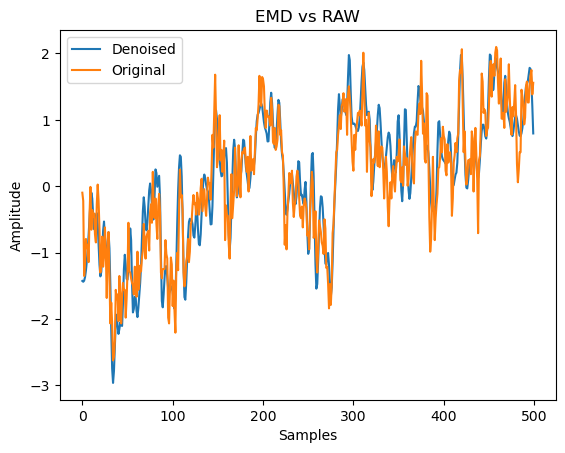

array([-1.42671629, -1.43910045, -1.42305458, ..., -0.02209812,
        0.21826198,  0.04192046])

In [462]:
import matplotlib.pyplot as plt
emd_plotted = results_emd_dataset[0]['denoised_signals'][0]
plt.plot(emd_plotted[:500], label = "Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

emd_plotted

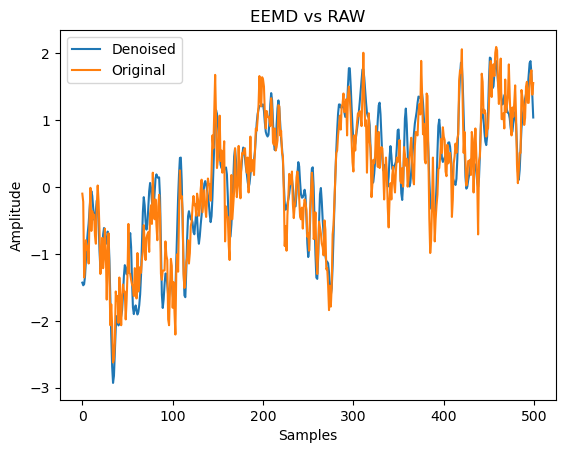

In [464]:
denoised_plotted = results_eemd[0]['denoised_signals'][0]

plt.plot(denoised_plotted[:500], label="Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EEMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


# Power Spectral Decomposition

In [467]:
results_eemd[0]

{'parameter_sets': [0.4, 0.3, 0.2, 0.1, 0.05],
 'denoised_signals': [array([-1.42916971, -1.46858124, -1.45176386, ..., -0.11229259,
          0.09407924,  0.03854244]),
  array([-1.31064864, -1.35408335, -1.38769546, ..., -0.11801802,
          0.0526536 , -0.03401511]),
  array([-1.28787693, -1.38262987, -1.41096384, ..., -0.04317392,
          0.19956233,  0.05172986]),
  array([-1.37660141, -1.43585302, -1.44465677, ..., -0.01827278,
          0.21354802,  0.04940694]),
  array([-1.32090507, -1.3643899 , -1.37164298, ..., -0.04131197,
          0.19748977,  0.02675951])]}

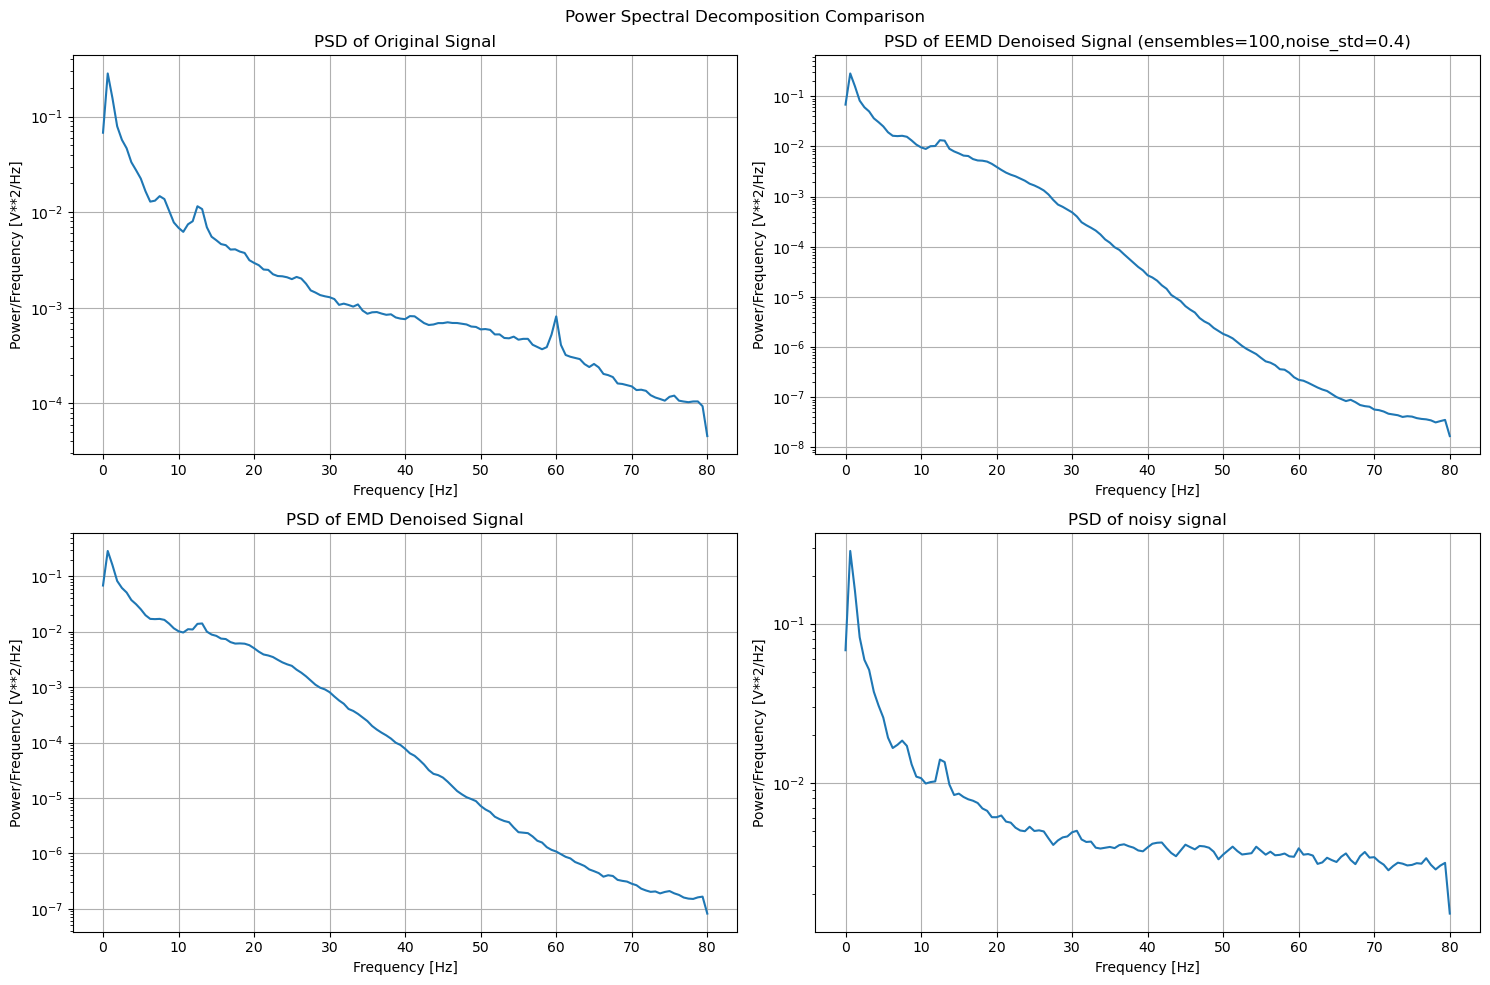

In [476]:
from scipy.signal import welch
psd_og_signal = original_eeg[0]
psd_eemd_signal = results_eemd[0]['denoised_signals'][0]
psd_noisy_signal = noisy_eeg[0]
psd_emd_signal = results_emd_dataset[0]['denoised_signals'][0]
plt.figure(figsize=(15, 10))
f1, Pxx1 = welch(psd_og_signal, fs=160)
f2, Pxx2 = welch(psd_eemd_signal, fs=160)
f3, Pxx3 = welch(psd_emd_signal, fs=160)
f4, Pxx4 = welch(psd_noisy_signal, fs=160)
plt.subplot(2,2,1)
plt.suptitle("Power Spectral Decomposition Comparison")
plt.semilogy(f1, Pxx1)
plt.title(f'PSD of Original Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,2)
plt.semilogy(f2, Pxx2)
plt.title(f'PSD of EEMD Denoised Signal (ensembles=100,noise_std=0.4)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,3)
plt.semilogy(f3, Pxx3)
plt.title(f'PSD of EMD Denoised Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,4)
plt.semilogy(f4, Pxx4)
plt.title(f'PSD of noisy signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.tight_layout()

plt.show()